## Import different required libraries, HIVE and Spark sessions

In [1]:
%%local
import os
import pickle
import math
import datetime
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt
%matplotlib inline
                                                                                                
import plotly.express as px
import plotly.graph_objects as go

In [2]:
%%local
from IPython import get_ipython
ipython = get_ipython()

root_data = "../data/"
username = 'parchet' # if you don't want to rederive all HDFS tables
# username = os.environ['JUPYTERHUB_USER'] # If you whish to derive everything from scratch

ipython.run_cell_magic('configure','-f','{{ "name":"final-{0}" }}'.format(username))
print("Runnuing as user: ", username)

Runnuing as user:  parchet


In [3]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
7302,application_1618324153128_7037,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
import math
import numpy as np
import pyspark.sql.functions as SFunc
import pyspark.sql.functions as F
from pyspark.sql import Window

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
%%local
hiveaddr = os.environ['HIVE_SERVER_2']
print("Operating as: {0}".format(username))
print("Operating on hiveaddr: {0}".format(hiveaddr))

Operating as: parchet
Operating on hiveaddr: iccluster065.iccluster.epfl.ch


In [6]:
%%local
from pyhive import hive

# create connection
conn = hive.connect(host=hiveaddr, 
                    port=10000,
                    username=username) 
# create cursor
cur = conn.cursor()

<div style="font-size: 150%" class="alert alert-block alert-warning">
    Before jumping into the notebook, note that you can skip part 1 and 2 if you do not whish to rederive all the data from scratch! (you can set username='parchet' in cell 2 if you have never built the HDFS tables)
</div>

## I) Data Import & Wrangling:

#### A. First of all, if you have never done so, prepare the required orc tables in your personnal HDFS by running the notebook `PrepareTablesHDFS.ipynb`

#### B. Processing the geostops

We need the geostops both to pre-process the SBB istdaten and the timetables. As the geostops is quite small, we will simply process it once in a pandas dataframe for SBB istdaten usage and once in a spark Dataframe to use on the cluster.  
Note that alternatively we could store it on HDFS to prevent processing the dataset twice but given it's size and low complexity we decided not to. 

##### Import all the geostops from the previously created orc table in a local pandas dataframe:

In [7]:
%%local
query = """
    select STATIONID as id, REMARK as name, LATITUDE as lat, LONGITUDE as lon
    from {0}.sbb_geostops
""".format(username)
geostops_df = pd.read_sql(query, conn)

In [8]:
%%local
geostops_df.head(5)

Output()

In [9]:
%%local
data_types_dict = {'id': str, 'name': str, 'lat': float, 'lon': float}
geostops_df = geostops_df.astype(data_types_dict)

geostops_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39026 entries, 0 to 39025
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      39026 non-null  object 
 1   name    39026 non-null  object 
 2   lat     39026 non-null  float64
 3   lon     39026 non-null  float64
dtypes: float64(2), object(2)
memory usage: 6.0 MB


##### Now we will filter this dataframe to only keep the stops that are within the studied 15km around ZurichHB area: 

We deal here with a short distance (15km) and our accuracy doesn't have to be exact to the centimeter, so we can treat the surface of the earth as flat.
So to perform our check we can just make a conversion from degrees to kilometers at the latitude of the center point, then Pythagore's theorem to get the distance.

We could also use methods offered by libraries such as geopy / geo-py but this adds unnecessary complexity and additional library to the project.

In [10]:
%%local
# Some constants to determine points within 15km from Zürich HB based on their (lat,lon) coordinates
earth_radius = 6378.0
zurich_avg_altitude = 0.430
earth_circumference = 40075.0

def distance(lat1, lon1, lat2, lon2, earth_circumference=earth_circumference):
    """
    Computes the euclidean distance between two given points given their latitude and longitude coordinates
    Code inspiration: https://stackoverflow.com/questions/24680247/check-if-a-latitude-and-longitude-is-within-a-circle-google-maps
    """
    km_per_degree_lat = earth_circumference / 360.0
    km_per_degree_lon = math.cos(math.pi * lat2 / 180.0) * km_per_degree_lat
    dx = abs(lon2 - lon1) * km_per_degree_lon
    dy = abs(lat2 - lat1) * km_per_degree_lat
    return math.sqrt(dx*dx + dy*dy)

def dist_from_center(lat_lon_row, central_lat=47.378177, central_lon=8.540192,earth_circumference=earth_circumference):
    """
    Returns wether the distance of the given point (lat, long) from the central point (ZurichHB)
    """
    return distance(lat_lon_row.lat, lat_lon_row.lon, central_lat, central_lon,earth_circumference)

In [11]:
%%local
max_dist=15.0
geostops_df['center_dist'] = geostops_df.apply(dist_from_center, axis=1)
zurich_geostops_df = geostops_df[geostops_df.center_dist <= max_dist]

In [12]:
%%local
zurich_geostops_df.head()

Output()

In [13]:
%%local
zurich_geostops_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1947 entries, 65 to 39015
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1947 non-null   object 
 1   name         1947 non-null   object 
 2   lat          1947 non-null   float64
 3   lon          1947 non-null   float64
 4   center_dist  1947 non-null   float64
dtypes: float64(3), object(2)
memory usage: 350.2 KB


We can see that by considering only stops within Zürich area, we keep 1947 stops over the total 39026.

In [14]:
%%local
unique_stop_ids = len(set(zurich_geostops_df.id.tolist()))
unique_stop_names = len(set(zurich_geostops_df.name.tolist()))

print("Also remark that in those stops even so all %s stops have distinct Id, only %s have distinct names." %(unique_stop_ids, unique_stop_names))

Also remark that in those stops even so all 1947 stops have distinct Id, only 1601 have distinct names.


In [15]:
%%local
# convert and save the dataframe to pickle
pickle.dump(zurich_geostops_df, open(root_data+"zurich_geostops_df.pickle", "wb"))

##### Similar procedure to create Spark Dataframe for timetable processing usage:

In [16]:
earth_circumference = 40075.0

@SFunc.udf
def distance(lat1, lon1, lat2=47.378177, lon2=8.540192, earth_circumference=earth_circumference):
    """
    Computes the euclidean distance between two given points given their latitude and longitude coordinates
    Code inspiration: https://stackoverflow.com/questions/24680247/check-if-a-latitude-and-longitude-is-within-a-circle-google-maps
    """
    km_per_degree_lat = earth_circumference / 360.0
    km_per_degree_lon = math.cos(math.pi * lat2 / 180.0) * km_per_degree_lat
    dx = abs(lon2 - lon1) * km_per_degree_lon
    dy = abs(lat2 - lat1) * km_per_degree_lat
    return math.sqrt(dx*dx + dy*dy)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
max_dist=15.0

geostops = spark.read.orc("/data/sbb/orc/geostops")
geostops = geostops.withColumn('distance', distance(geostops['stop_lat'], geostops['stop_lon'])).filter(SFunc.col('distance') <= max_dist)
geostops = geostops.drop('location_type', 'parent_station')
geostops.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+----------------+----------------+------------------+
|stop_id|           stop_name|        stop_lat|        stop_lon|          distance|
+-------+--------------------+----------------+----------------+------------------+
|8557033|Oberhasli, Industrie|47.4592670391304|8.49001368400678| 9.787338964326114|
|8573711|   Zürich, Sädlenweg|47.3677549978138|8.48748043490521|4.1393435448144755|
|8591828|    Ebmatingen, Dorf|47.3513920447801|8.64100251698261| 8.163194166284272|
|8590610|Fällanden, Schütz...| 47.368625031339|8.63247750493513| 7.037338394797212|
|8580617|    Bülach, Engelwis|47.5111891951511|8.53713032066541| 14.80864220993802|
+-------+--------------------+----------------+----------------+------------------+
only showing top 5 rows

#### C. Processing the timetables data:

We will create a dataframe corresponding only to the schedules on May 13-17, 2019. As this is a typical week schedule, we will use it as our base timetable:

In [18]:
#import calendar data

calendar = spark.read.csv("/data/sbb/csv/timetable/calendar/2019/05/07/calendar.csv", header=True, encoding='utf8')
calendar.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+------+-------+---------+--------+------+--------+------+----------+--------+
|service_id|monday|tuesday|wednesday|thursday|friday|saturday|sunday|start_date|end_date|
+----------+------+-------+---------+--------+------+--------+------+----------+--------+
|  TA+b0006|     1|      1|        1|       1|     1|       0|     0|  20181209|20191214|
|  TA+b0ch2|     0|      0|        0|       0|     0|       1|     1|  20181209|20191214|
|  TA+b0014|     0|      0|        0|       0|     0|       0|     1|  20181209|20191214|
|  TA+b000w|     0|      0|        0|       0|     0|       1|     0|  20181209|20191214|
|  TA+b001b|     1|      1|        1|       1|     1|       1|     0|  20181209|20191214|
+----------+------+-------+---------+--------+------+--------+------+----------+--------+
only showing top 5 rows

In [19]:
#import trips data

trips = spark.read.csv("/data/sbb/csv/timetable/trips/2019/05/07/trips.csv", header=True, encoding='utf8')
trips.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+--------------------+---------------+------------+
|   route_id|service_id|             trip_id|trip_short_name|direction_id|
+-----------+----------+--------------------+---------------+------------+
| 1-85-j19-1|  TA+b0001| 2.TA.1-85-j19-1.1.H|          85003|           0|
|1-1-C-j19-1|  TA+b0001|5.TA.1-1-C-j19-1.3.R|            108|           1|
|1-1-C-j19-1|  TA+b0001|7.TA.1-1-C-j19-1.3.R|            112|           1|
|1-1-C-j19-1|  TA+b0001|9.TA.1-1-C-j19-1.3.R|            116|           1|
|1-1-C-j19-1|  TA+b0001|11.TA.1-1-C-j19-1...|            120|           1|
+-----------+----------+--------------------+---------------+------------+
only showing top 5 rows

In [20]:
#import routes data

routes = spark.read.csv("/data/sbb/csv/timetable/routes/2019/05/07/routes.csv", header=True, encoding='utf8')
routes.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+---------+----------------+---------------+----------+----------+
|   route_id|agency_id|route_short_name|route_long_name|route_desc|route_type|
+-----------+---------+----------------+---------------+----------+----------+
|11-40-j19-1|      801|             040|           null|       Bus|       700|
|11-61-j19-1|     7031|             061|           null|       Bus|       700|
|11-62-j19-1|     7031|             062|           null|       Bus|       700|
|24-64-j19-1|      801|             064|           null|       Bus|       700|
|11-83-j19-1|      801|             083|           null|       Bus|       700|
+-----------+---------+----------------+---------------+----------+----------+
only showing top 5 rows

In [21]:
#import stop_time data

timetable = spark.read.csv("/data/sbb/csv/timetable/stop_times/2019/05/07/stop_times.csv", header=True, encoding='utf8')
timetable.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------+--------------+-------+-------------+-----------+-------------+
|            trip_id|arrival_time|departure_time|stop_id|stop_sequence|pickup_type|drop_off_type|
+-------------------+------------+--------------+-------+-------------+-----------+-------------+
|1.TA.1-84-j19-1.1.H|    06:13:00|      06:13:00|8572249|            1|          0|            0|
|1.TA.1-84-j19-1.1.H|    06:14:00|      06:14:00|8577508|            2|          0|            0|
|1.TA.1-84-j19-1.1.H|    06:15:00|      06:15:00|8581070|            3|          0|            0|
|1.TA.1-84-j19-1.1.H|    06:16:00|      06:16:00|8578360|            4|          0|            0|
|1.TA.1-84-j19-1.1.H|    06:17:00|      06:17:00|8583448|            5|          0|            0|
+-------------------+------------+--------------+-------+-------------+-----------+-------------+
only showing top 5 rows

Fist of all we noted that most of those trips have duration under 1min (which makes sense for all bus stops close in location):

In [22]:
trips_count = timetable.count()
long_trips_count = timetable[timetable.departure_time != timetable.arrival_time].count()
print("Over the {0} stops, only {1} have duration higher than a minute.".format(trips_count, long_trips_count))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Over the 10862563 stops, only 448589 have duration higher than a minute.

##### Let's now only keep the trips that were made within our area of interest:

In [23]:
#list of all stop_id that are in Zurich
zurich_stops = set([str(stop.stop_id) for stop in geostops.select('stop_id').collect()])

#filter the timetable to only contains Stops that are in Zurich
zurich_timetable=timetable.filter(F.col('stop_id').isin(zurich_stops))
zurich_timetable.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------+-------+-------------+-----------+-------------+
|             trip_id|arrival_time|departure_time|stop_id|stop_sequence|pickup_type|drop_off_type|
+--------------------+------------+--------------+-------+-------------+-----------+-------------+
|1.TA.1-N31-j19-1.1.R|    25:25:00|      25:25:00|8587020|            1|          0|            0|
|1.TA.1-N31-j19-1.1.R|    25:27:00|      25:27:00|8590535|            2|          1|            0|
|1.TA.1-N31-j19-1.1.R|    25:27:00|      25:27:00|8590222|            3|          1|            0|
|1.TA.1-N31-j19-1.1.R|    25:28:00|      25:28:00|8590218|            4|          1|            0|
|1.TA.1-N31-j19-1.1.R|    25:30:00|      25:30:00|8590521|            5|          1|            0|
+--------------------+------------+--------------+-------+-------------+-----------+-------------+
only showing top 5 rows

##### We generate the mapping between trip_id and the transport type
- First, generate all pairs trip_id & transport_type that are in Zürich
- Second, display every distinct transport type
- Third, create a dictionnary that will map the precise transport type label into 4 simple type $\in$ {Train,Tram,Bus,NotSupported}
- Fourth, replace all the precise type by the simple ones
- Fifth, send it to local to convert it into a dictionnary and save it as a pickle object

In [24]:
%%spark -o tripID_to_ttype -n -1

#First
print("First")
tripID_to_ttype=timetable.select("trip_id","stop_id")\
                        .filter(F.col('stop_id').isin(zurich_stops))\
                        .drop("stop_id").distinct()\
                        .join(trips.select("route_id","trip_id"),"trip_id")\
                        .join(routes.select("route_id","route_desc"),"route_id").drop("route_id")\
                        .withColumnRenamed("route_desc","ttype")

tripID_to_ttype.show(3)

#Second
print("Second\nAll distinct transport types")
tripID_to_ttype.select("ttype").distinct().show()

#Third
# value in {Train,Tram,Bus,NotSupported}
precise_to_simple_ttype= {
    "TGV":"Train",
    "Eurocity":"Train",
    "Regionalzug":"Train",
    "RegioExpress":"Train",
    "S-Bahn":"Train",
    "Tram":"Tram",
    "ICE":"Train",
    "Bus":"Bus",
    "Eurostar":"Train",
    "Intercity":"Train",
    "InterRegio":"Train",
    "Extrazug":"Train"
}

@SFunc.udf
def precise_to_simple_ttype_function(key):
    return precise_to_simple_ttype.get(key,"NotSupported")

#Fourth
print("Fourth")
tripID_to_ttype=tripID_to_ttype.withColumn("ttype",precise_to_simple_ttype_function(tripID_to_ttype["ttype"]))
tripID_to_ttype.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

First
+--------------------+--------+
|             trip_id|   ttype|
+--------------------+--------+
|1.TA.26-18-j19-1.1.H|  S-Bahn|
|1.TA.63-138-Y-j19...|Extrazug|
|10.TA.26-77-j19-1...|     Bus|
+--------------------+--------+
only showing top 3 rows

Second
All distinct transport types
+-------------+
|        ttype|
+-------------+
|          TGV|
|     Eurocity|
|Standseilbahn|
|  Regionalzug|
| RegioExpress|
|       S-Bahn|
| Luftseilbahn|
|         Taxi|
|         Tram|
|          ICE|
|          Bus|
|     Eurostar|
|       Schiff|
|    Intercity|
|   InterRegio|
|     Extrazug|
+-------------+

Fourth
+--------------------+-----+
|             trip_id|ttype|
+--------------------+-----+
|1.TA.26-18-j19-1.1.H|Train|
|1.TA.63-138-Y-j19...|Train|
|10.TA.26-77-j19-1...|  Bus|
+--------------------+-----+
only showing top 3 rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
%%local
#Fifth
tripID_to_ttype_dict=tripID_to_ttype.set_index("trip_id")["ttype"].T.to_dict()

pickle.dump(tripID_to_ttype_dict, open(root_data+"tripID_to_ttype_dict.pickle", "wb"))

##### Create all the connections in our dataframe and the footpath connection

In [26]:
from pyspark.sql import Window
import pyspark.sql.functions as F

#partition by trip_id order by arrival_time and get the next stop_id and next arrival_time
#and join with calendar and trips dataframe in order to retrieve the weekday

rolling_pair_window=Window.partitionBy("trip_id").orderBy("arrival_time")

next_arrival=F.lead("arrival_time").over(rolling_pair_window).alias("arr_time")
next_stop_id=F.lead("stop_id").over(rolling_pair_window).alias("arr_stop")

connections=zurich_timetable.select("trip_id","departure_time","stop_id",next_arrival,next_stop_id)\
                            .na.drop("any")\
                            .withColumnRenamed("stop_id","dep_stop")\
                            .withColumnRenamed("departure_time","dep_time")\
                            .where("SUBSTR(dep_time,1,2)>=7 and SUBSTR(arr_time,1,2)<=20")\
                            .join(trips.select("trip_id","service_id"),"trip_id")\
                            .join(calendar,"service_id")\
                            .drop("service_id","start_date","end_date")

connections.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+-----------+--------+-----------+------+-------+---------+--------+------+--------+------+
|             trip_id|dep_time|   dep_stop|arr_time|   arr_stop|monday|tuesday|wednesday|thursday|friday|saturday|sunday|
+--------------------+--------+-----------+--------+-----------+------+-------+---------+--------+------+--------+------+
|1.TA.26-18-j19-1.1.H|10:41:00|    8503064|10:45:00|8503065:0:1|     1|      1|        1|       1|     1|       0|     0|
|1.TA.26-18-j19-1.1.H|10:45:00|8503065:0:1|10:46:00|    8503074|     1|      1|        1|       1|     1|       0|     0|
|1.TA.26-18-j19-1.1.H|10:46:00|    8503074|10:47:00|    8503068|     1|      1|        1|       1|     1|       0|     0|
|1.TA.26-18-j19-1.1.H|10:47:00|    8503068|10:48:00|    8503066|     1|      1|        1|       1|     1|       0|     0|
|1.TA.26-18-j19-1.1.H|10:48:00|    8503066|10:50:00|    8503075|     1|      1|        1|       1|     1|       0|     0|
+--------------------+--

In [27]:
max_foot_distance=0.5 # in km
walking_speed_kmPerMin=0.05 # in km/min

# determine the duration (in minutes)
footpaths=geostops.alias('l').join(geostops.alias('r'))\
                .where('abs(r.distance- l.distance)<{0} and l.stop_id<>r.stop_id'.format(max_foot_distance))\
                .select(F.col('l.stop_id').alias('dep_stop'),
                        F.col('r.stop_id').alias('arr_stop'),
                        distance(F.col('l.stop_lat'),F.col('l.stop_lon'),F.col('r.stop_lat'),F.col('r.stop_lon')).alias('distance'))\
                .where('distance<{0}'.format(max_foot_distance))\
                .select('dep_stop',
                        'arr_stop',
                        (F.col('distance')/walking_speed_kmPerMin).alias('dur'))

footpaths.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------+-----------------+
|dep_stop|arr_stop|              dur|
+--------+--------+-----------------+
| 8573711| 8591214|7.077161107589709|
| 8573711| 8591163|9.235644479877227|
| 8590610| 8590612|9.833684661001282|
| 8590610| 8590605|7.408694523734566|
| 8590610| 8590752| 5.90775680493275|
+--------+--------+-----------------+
only showing top 5 rows

#### D. Processing the required istDaten SBB data:

In order to train our model, we will first make an external table only containing all the journeys that:
- Are between two stations within 15km of Zurich main train station ('Zürich HB (8503000)', lat=47.378177, lon=8.540192)
- Standard date of trip format
- Non empty product id
- for Trains and Bus we check AN_PROGNOSE_STATUS and AB_PROGNOSE_STATUS are equal to REAL or GESCHAETZT. 
- After some more research it appears Trams in Zurich do not have REAL or GESCHAETZT prognose so for this 

Additionally, we realized that on the Swiss scale, all the main means of transport have a fair share of journeys with prognostics either REAL or GESCHAETZT but in Zurich in particular, there are not enough tram journeys with these information to provide us an estimate of the delays.

Therefore, for this particular mean of transport, we will also allow forcasted values (PROGNOSE) so that we can determine an approximate estimate of the trams delays.

In [28]:
%%local
within_15_stop_stations = tuple(set(zurich_geostops_df.name.tolist()))

query = """
    drop table if exists {0}.zurich_istdaten
""".format(username)
cur.execute(query)

query = """
    create external table {0}.zurich_istdaten
    as
    select FAHRT_BEZEICHNER as trip_id, lower(PRODUKT_ID) as ttype, LINIEN_ID as train_nb, FAELLT_AUS_TF as trip_failed, DURCHFAHRT_TF as no_stop,
    HALTESTELLEN_NAME as stop_name, ZUSATZFAHRT_TF as unplanned_trip, LINIEN_TEXT as linien, VERKEHRSMITTEL_TEXT as verkehrsmittel,
    unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyyy HH:mm') as expected_ar, unix_timestamp(AN_PROGNOSE,'dd.MM.yyyy hh:mm:ss') as actual_ar,
    unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyyy HH:mm') as expected_dep, unix_timestamp(AB_PROGNOSE,'dd.MM.yyyy hh:mm:ss') as actual_dep
    from {0}.sbb_orc
    where BETRIEBSTAG like '__.__.____' and PRODUKT_ID is not NULL and PRODUKT_ID <> ''
    and HALTESTELLEN_NAME in {1}
    and ( (AN_PROGNOSE_STATUS in ('REAL', 'GESCHAETZT') and AB_PROGNOSE_STATUS in ('REAL', 'GESCHAETZT')) 
    or (lower(PRODUKT_ID)=='tram' and AN_PROGNOSE_STATUS!='UNBEKANNT' and AB_PROGNOSE_STATUS!='UNBEKANNT') ) 
""".format(username, within_15_stop_stations)
cur.execute(query)

In [29]:
%%local
query = """
    select *, floor((actual_ar-expected_ar)/(12))
    from {0}.zurich_istdaten
    where ttype = 'bus' and extract(hour from FROM_UNIXTIME(expected_ar)) = 12 and ((floor(expected_ar/86400) + 4) % 7+1) = 1
    limit 5
""".format(username)
tr_sbb_df = pd.read_sql(query, conn)

In [30]:
%%local
print(tr_sbb_df.columns)
tr_sbb_df.head()

Index(['zurich_istdaten.trip_id', 'zurich_istdaten.ttype',
       'zurich_istdaten.train_nb', 'zurich_istdaten.trip_failed',
       'zurich_istdaten.no_stop', 'zurich_istdaten.stop_name',
       'zurich_istdaten.unplanned_trip', 'zurich_istdaten.linien',
       'zurich_istdaten.verkehrsmittel', 'zurich_istdaten.expected_ar',
       'zurich_istdaten.actual_ar', 'zurich_istdaten.expected_dep',
       'zurich_istdaten.actual_dep', '_c1'],
      dtype='object')


Output()

## II) Determine delays heuristically

We query from the previously created external HDFS table zurich_istdaten:

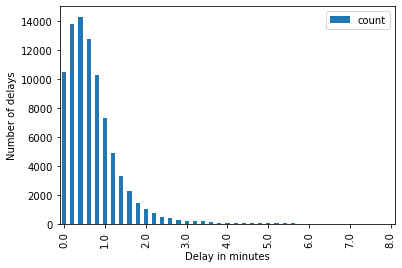

In [31]:
%%local

# Set at 12, every delay (in seconds) will be grouped by bucket of size 12 seconds : [0,11], [12,25], .. 
bucket_size = 12 
query="""
    (select S.ttype as ttype,  S.day as day, S.hour as hour, S.delay as delay, count(*) as count 
    FROM (SELECT t.ttype, (floor(t.expected_ar/86400) + 4) % 7 as day, extract(hour from FROM_UNIXTIME(t.expected_ar)) as hour, floor((t.actual_ar-t.expected_ar)/{1})*{1}/60 as delay
    FROM {0}.zurich_istdaten T) S
    WHERE s.delay <= 8 and S.delay >= 0
    GROUP BY S.ttype,  S.day, S.delay, S.hour
    ORDER BY S.ttype,  S.day, S.delay, S.hour)
""".format(username,bucket_size)
dis = pd.read_sql(query, conn)

ax = dis[(dis['ttype'] == 'zug') & (dis['day'] == 0) & (dis['hour'] == 8)].plot.bar(x='delay',y='count')
ax.set_ylabel('Number of delays')
ax.set_xlabel('Delay in minutes')
ax.xaxis.set_major_locator(plt.MaxNLocator(9))

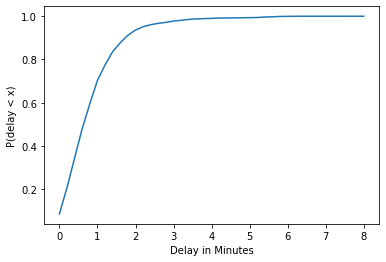

In [32]:
%%local

# Create dictionnary of delays distributions for Bus, Trams and Trains depending on the day and hour (working hours)
cdf = {} 

for ttype in ['bus','zug','tram']:
    cdf_day = {}
    for day in [0,1,2,3,4,5,6]:
        cdf_hour = {}
        for hour in range(6,22):
            hist = dis[(dis['ttype'] == ttype) & (dis['day'] == day) & (dis['hour'] == hour)]['count'].to_numpy()
            while len(hist) < 41 and len(hist) != 0 :
                hist = np.append(hist,0.0)
            if len(hist) == 0:
                hist = np.zeros(41)
                hist[0] = 1
                
            cdf_hour[hour] = np.cumsum(hist/hist.sum())
        cdf_day[day] = cdf_hour
    cdf[ttype]=cdf_day
    
cdf['Bus'] = cdf['bus']
cdf['Train'] = cdf['zug']
cdf['Tram'] = cdf['tram']

del cdf['bus']
del cdf['zug']
del cdf['tram']

#save it as a pickle object
pickle.dump(cdf, open(root_data+"cdf.pickle", "wb"))


# Cumulative Distribution Function of the delay (not arrival time, the *delay*) of a BUS on WEDNESDAY at 10:00
plt.ylabel('P(delay < x)')
plt.xlabel("Delay in Minutes")
plt.plot(np.linspace(0,8,41),cdf['Bus'][0][9]) 

## III) Find the best journeys: the Connection Scan Algorithm (CSA)

#### Save in Local the required datasets: Connections and Footpaths

In [33]:
%%local
#list the files
!git lfs ls-files 
# Pull from git lfs our pickles
!git lfs pull

bc37e5d16a - data/cdf.pickle
7b6e64eef6 - data/connections.pickle
4bc7ba99e3 - data/footpaths.pickle
632ef2bbb5 - data/tr_sbb_df.pickle
e1a2cdedb0 - data/tripID_to_ttype_dict.pickle
01422b1e3d - data/zurich_geostops_df.pickle
cb466fa63b - figs/CSA_algo_pseudocode.pdf
f81eb05578 - figs/journeys.png
ef5da4ac0f - figs/journeys.svg
a624c3a716 - figs/trip_image.PNG
fea80d49cc - figs/trip_textual.PNG


In [34]:
%%local
from collections import defaultdict

#define function to be wrapped around the import of cdf
def from_cdf_to_default(cdf):
    cdf_day = {}
    for day in [0,1,2,3,4,5,6]:
        cdf_hour = {}
        for hour in range(6,22):
            current_cdf = np.zeros(41)
            for ttype in ['Bus','Train','Tram']:
                current_cdf += cdf[ttype][day][hour]
            cdf_hour[hour] = current_cdf/3
        cdf_day[day] = cdf_hour
        
    return defaultdict(lambda:cdf_day,cdf)

# load dataset

# Geostops
geostops=pickle.load(open(root_data+"zurich_geostops_df.pickle",'rb'))

# Footpaths
footpaths = np.array(pd.read_pickle(root_data+"footpaths.pickle"))

# Connections
connections = pd.read_pickle(root_data+"connections.pickle")

trips = connections['trip_id'].unique()

connections['dep_time']=pd.to_datetime(connections['dep_time'])
connections['arr_time']=pd.to_datetime(connections['arr_time'])

# split the connections by week day
weekday_list=["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]
connections_week=[]
for idx,weekday in enumerate(weekday_list):
    temp = connections[connections[weekday]=='1'][['trip_id','dep_time','dep_stop','arr_time','arr_stop']].sort_values(by=['arr_time'])
    connections_week.append( np.array(temp) )

#### CSA algorithm setup

In [35]:
%%local

stops = geostops['id']
stops_names = dict(zip(stops,geostops['name']))
tripID_to_ttype_dict=pickle.load(open(root_data+"tripID_to_ttype_dict.pickle",'rb'))
cdf=from_cdf_to_default(pickle.load(open(root_data+"cdf.pickle",'rb')))

date_init = pd.to_datetime('00:00:00')
delta = pd.to_timedelta(2, unit='m')

#### Algorithm Descriprtion 
##### (revisited CSA algorithm to maximize the departure time)

![algo](../figs/algo.png)

In [36]:
%%local

def CSA(starting_stop, arrival_stop, arrival_time, weekday, avoid=[]):
    '''
    Connections Scan Algorithm to maximize the starting time
    
    Return: List of trips, where each trip is a list of 5 elements: 
                [means of transport (trip ID or 'walking'), starting time (datetime), starting_stop (name), arriving_time (datetime), arriving stop (name)]
                
    '''   
    
    S = dict.fromkeys(stops, [None, date_init, None, None, None]) # {from: [starting_time, to, how]}
    T = dict.fromkeys(trips, False)
    S[arrival_stop] = [None, arrival_time, arrival_stop, None, None]
    for footpath in footpaths[ footpaths[:,0]==arrival_stop ]:
        S[footpath[1]] = ['Walking', arrival_time-footpath[2], footpath[1], arrival_time, arrival_stop]
    
    
    connections = connections_week[weekday]
    lowest = 0
    highest = connections.shape[0]
    
    def binary_search(tau, low=lowest, high=highest):
        '''
        Binary Search 
        
        Return: An integer, Index of the first connection arring at 'tau' 
        '''
        if high > low:
            mid = (high + low) // 2
            arr_time = connections[mid,3]

            if arr_time == tau:
                return mid
            elif arr_time > tau:
                return binary_search(tau, low, mid - 1)
            else:
                return binary_search(tau, mid + 1, high)

        if high == low:
            mid = high
            arr_time = connections[mid,3]
            if arr_time <= tau:
                return mid
            else:
                return mid-1

        else:
            return TypeError('Wrong Inizialiaztion in Binary Search: \'high\' has to be at least as big as \'low\'')
    
    
    c_0 = binary_search(arrival_time)
    for connection in connections[c_0::-1]:
        if not (connection[0] in avoid): 
            if S[starting_stop][1] >= connection[3]:
                break
            if T[connection[0]] or S[connection[4]][1]>=connection[3]+delta:
                if S[connection[2]][1]<connection[1]:
                    T[connection[0]] = True
                    S[connection[2]] = list(connection)
                    for footpath in footpaths[ footpaths[:,0]==connection[2] ]:
                        if S[footpath[1]][1]<(connection[1]-(footpath[2])):
                            S[footpath[1]] = ['Walking', connection[1]-footpath[2], footpath[1], connection[1], footpath[0]]                        

    if S[starting_stop][0]!=None:
        path = []
        mof = None
        step = S[starting_stop]
        while step[0]!=None:
            if step[0]!=mof:
                if step[2]!=starting_stop:
                    path[-1][3] = old[3]
                    path[-1][4] = old[4]
                path.append(step)
                mof = step[0]
                old = step
            else:
                old = step
            step = S[step[4]]
        if step[0]!=mof:
            path[-1][3] = old[3]
            path[-1][4] = old[4]
        path.append(step)
        return path
    
    else:
        #print('No path exists starting from "{}" and arriving to "{}" by {} on {}'.format(starting_stop, arrival_stop, arrival_time, weekday_list[weekday]))
        return []

In [37]:
%%local

def describe(path):
    prob = confidence_interval(path)[0]
    print('Confidence Level: {0:.2f}%, Departure Time: {1}\n'.format(prob*100, path[0][1].time()))
    for step in path:
        if step[0]!=None:
            if step[0]!='Walking':
                print('From "{}" at {} take {}-"{}" reaching "{}" at {}'.format(stops_names[step[2]], step[1].time(),tripID_to_ttype_dict[step[0]],step[0], stops_names[step[4]], step[3].time()))
            else: 
                print('From "{}" walk up to "{}" ({} minutes needed)'.format(stops_names[step[2]], stops_names[step[4]], int((step[3]-step[1]).total_seconds()/60) ))
    print('\n')

In [38]:
%%local

def confidence_interval(path, verbose=False):
    p = 1
    min_p = 1
    min_trip = 0

    for i,trip in enumerate(path): 

        walking_between_stops = (trip[0] == 'Walking'  and i != len(path)-1 and i != 0)
        walking_in_a_stop = (i != 0 and trip[0] != 'Walking' and path[i-1][0] != 'Walking'  and trip[0] != path[i-1][0])
        current_p = 1
        if walking_between_stops or walking_in_a_stop:
            day = path[i-1][3].weekday()
            hour = path[i-1][3].hour
            ttype = tripID_to_ttype_dict[path[i-1][0]]
            current_p = 1
            if walking_between_stops:
                time_to_change = (path[i+1][1]-path[i-1][3]).seconds
                time_to_walk = (trip[3]-trip[1]).seconds
            elif walking_in_a_stop:
                time_to_change = (path[i][1]-path[i-1][3]).seconds
                time_to_walk = (120)
            if (time_to_change-time_to_walk)/60 < 8:
                current_p = cdf[ttype][day][hour][int((time_to_change-time_to_walk)/12)] # Probability that the (delay + time_to_walk) <= transition time 
                #print(time_to_change/60,time_to_walk/60,current_p)
                if current_p < min_p:
                    min_p = current_p
                    min_trip = path[i-1][0]

        p *= current_p
        
    if verbose: print("The probability of arriving in time is {}, and the trip the least likely to be made in time is {} with probability {}".format(p, min_trip, min_p))
        
    return p, min_trip

In [39]:
%%local

def query(from_, to_, by_, weekday, min_prob, avoid=[]):
    
    alternatives = []
    brute_force = (min_prob<0.99)
    i = 0
    
    if from_ == to_:
        raise ValueError('Starting stop and arrival stop are equal! Please choose two different stops.')
    
    path = CSA(from_, to_, by_, weekday, avoid)
    prob, dang = confidence_interval(path)
    if prob>min_prob:
            alternatives.append(path)
            min_prob=prob
    avoid.append(dang)
    
    while min_prob*(brute_force)<0.99 and i<50:
        
        path = CSA(from_, to_, by_, weekday, avoid)
        prob, dang = confidence_interval(path)
        
        if prob==1:
            alternatives.append(path)
            break
        
        if prob>min_prob:
            alternatives.append(path)
            min_prob=prob
        
        avoid.append(dang)
        i +=1
        
        
    if alternatives==[]: 
        print('No path exists for such a query')
    
    return alternatives

#### Now that all our required functions are defined, we can try out a first manual journey search:

In [40]:
%%local

from_ = '8591122'
to_ = '8503500'
by_ = pd.to_datetime('18:00:00')
weekday = 1 # Tuesday
Q = 0.95
avoid = []

print('From: ', stops_names[from_])
print('To: ', stops_names[to_])
print('By: ', by_.time())
print('On: ', weekday_list[weekday].capitalize())
print('Minimum Confidence Level: {}%\n\n'.format(Q*100))


paths = query(from_, to_, by_, weekday, Q, avoid)
n_paths = len(paths)
if n_paths==1: print('An optimal path is found!')
else: print('{} optimal paths are found!'.format(n_paths))
        
for i,path in enumerate(paths):
    print('\n\nAlternative: ', i+1)
    describe(path)

From:  Zürich, ETH Hönggerberg
To:  Zürich Polyterrasse
By:  18:00:00
On:  Tuesday
Minimum Confidence Level: 95.0%


2 optimal paths are found!


Alternative:  1
Confidence Level: 96.86%, Departure Time: 17:34:00

From "Zürich, ETH Hönggerberg" at 17:34:00 take Bus-"138.TA.26-E-j19-1.5.H" reaching "Zürich, Haldenegg" at 17:47:00
From "Zürich, Haldenegg" walk up to "Zürich Polyterrasse" (7 minutes needed)




Alternative:  2
Confidence Level: 100.00%, Departure Time: 17:14:00

From "Zürich, ETH Hönggerberg" at 17:14:00 take Bus-"139.TA.26-E-j19-1.5.H" reaching "Zürich, Haldenegg" at 17:27:00
From "Zürich, Haldenegg" walk up to "Zürich Polyterrasse" (7 minutes needed)




#### Let's evaluate also the average computation time

In [41]:
%%local
import random
import time

n = 100
A = random.sample(list(stops), n)
B = random.sample(list(stops), n)
by_ = pd.to_datetime('13:00:00')
weekday = 1 # Tuesday

times = []
for a,b in zip(A,B):
    start = time.time()
    CSA(a, b, by_, weekday)
    end = time.time()
    times.append(end-start)

times = np.array(times)
mean = np.mean(times)
std = np.std(times)

print('The average computation time is {0:.2f}±{1:.2f} seconds'.format(mean, std))

The average computation time is 0.28±0.15 seconds


## IV) Vizualization and interactive interface:

In [42]:
%%local

def visualize_path(path):
    #re-import geostops to improve independence
    geostops=pickle.load(open(root_data+"zurich_geostops_df.pickle",'rb'))
    #to retrieve the coordinate easier
    geostops_id=geostops.set_index("id")
    
    #dict to map transport type to color and to accumulator
    ttype_to_color={"Walking":"#4A48D9","Train":"#FFAE00","Tram":"#8000FF","Bus":"#33A140","NotSupported":"#FF0000"}
    already_created_legend={"Walking":0,"Train":0,"Tram":0,"Bus":0,"NotSupported":0}

    fig = go.Figure()

    #for each section in the path, display it
    for trip_ID,_,stop0,_,stop1 in path[:-1]:
        lat_0,lon_0=geostops_id.loc[stop0][["lat","lon"]]
        lat_1,lon_1=geostops_id.loc[stop1][["lat","lon"]]
        ttype=tripID_to_ttype_dict.get(trip_ID,"Walking")

        display=False
        if already_created_legend[ttype]==0:
            display=True
            already_created_legend[ttype]=1

        fig.add_trace(go.Scattermapbox(mode = "lines",
                                        lon = [lon_0,lon_1],
                                        lat = [lat_0,lat_1],
                                        name=ttype,
                                        showlegend=display,
                                        marker = {'color':ttype_to_color[ttype]},
                                        line={'width':4}))

        fig.add_trace(go.Scattermapbox(mode = "markers",
                                        lon = [lon_0],
                                        lat = [lat_0],
                                        hovertext=geostops_id.loc[stop0]["name"],
                                        showlegend=False,
                                        marker = {'size': 20,'color':ttype_to_color[ttype]}))

    #for the last point
    trip_ID=path[-2][0]
    stop0=path[-1][2]
    lat_0,lon_0=geostops_id.loc[stop0][["lat","lon"]]
    ttype=tripID_to_ttype_dict.get(trip_ID,"Walking")
    fig.add_trace(go.Scattermapbox(mode = "markers",
                                    lon = [lon_0],
                                    lat = [lat_0],
                                    hovertext=geostops_id.loc[stop0]["name"],
                                    showlegend=False,
                                    marker = {'size': 20,'color':ttype_to_color[ttype]}))

    fig.update_layout(
        margin ={'l':0,'t':0,'b':0,'r':0},
        mapbox = {
            'center': {'lon': 8.540192, 'lat':47.378177 },
            'style': "open-street-map",
            'zoom':11})

    fig.show()

## Interactive journey planner

In [43]:
%%local
import ipywidgets as widgets
from IPython.display import display

output = widgets.Output()

all_stop_n_id=list(map(lambda x:tuple(x),geostops[["name","id"]].sort_values(by="name").values))

slider=widgets.FloatSlider(
    value=0.95,
    min=0,
    max=1.0,
    step=0.01,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

start=widgets.Dropdown(
    options=all_stop_n_id,
    value="8591122"
)

end=widgets.Dropdown(
    options=all_stop_n_id,
    value="8503500"
)

date_picker=widgets.DatePicker(
    description='Pick a Date',
    value = datetime.date(2021,6,4)
)

hour=widgets.Dropdown(
    options=range(7,21),
    value=13,
    description='Hour:',
    disabled=False,
)

minute=widgets.Dropdown(
    options=range(0,60),
    value=0,
    description='Minute:',
    disabled=False,
)


def on_button_clicked(b):
    #reset display
    output.clear_output()

    #get all value of widget

    Q=slider.value
    starting_stop=start.value
    arrival_stop=end.value
    
    weekday=date_picker.value.weekday()
    avoid =[]
    
    arrival_time=pd.to_datetime("%02d:%02d:00"%(hour.value,minute.value))
    
    
    with output:
        #this line also print confidence level
        paths = query(starting_stop, arrival_stop, arrival_time, weekday, Q, avoid)
        n_paths = len(paths)
        if n_paths==1: print('An optimal paths is found!')
        else: print('{} optimal paths are found!'.format(n_paths))
        
        for i,path in enumerate(paths):
            print('\n\nAlternative: ', i+1)
            describe(path)
            visualize_path(path)
        

#initalize button
button = widgets.Button(
    description='RUN',
    button_style='info',
    tooltip='RUN the research'
)
button.on_click(on_button_clicked)

#group all widget
widget_by_row =[widgets.HBox([widgets.Label("Min Confidence Level"), slider]),
                widgets.HBox([widgets.Label("Starting station"), start]),
                widgets.HBox([widgets.Label("Ending station"), end]),
                date_picker,
                widgets.HBox([hour,minute]),
                button]
#arrange them in a column
all_widget_in_one=widgets.VBox(widget_by_row)

#### Run the cell below to launch the interactive journey search:

In [44]:
%%local

display(all_widget_in_one,output)

Output()

## V) Validation of the results:

for example we could have one during rush hours, one during calm day-hour / one short journey, one long journey (if possible using different means of transports) / one allowing very low Q, one Q=99%

### This first cell is the reference. We will change some variables and see repercution on the result

An optimal paths is found!


Alternative:  1
Confidence Level: 100.00%, Departure Time: 12:34:00

From "Zürich, ETH Hönggerberg" at 12:34:00 take Bus-"153.TA.26-E-j19-1.5.H" reaching "Zürich, Haldenegg" at 12:47:00
From "Zürich, Haldenegg" walk up to "Zürich Polyterrasse" (7 minutes needed)




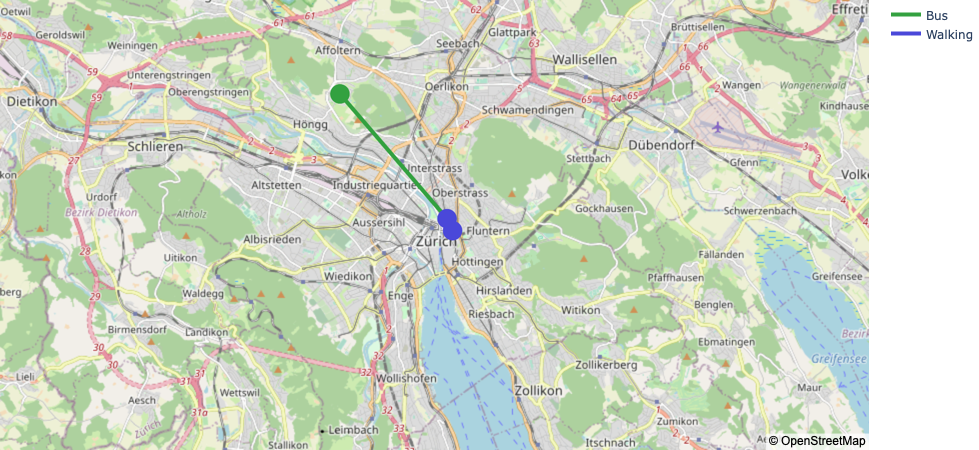

In [45]:
%%local
Q_0=0.95
starting_stop_0="8591122"
arrival_stop_0="8503500"
weekday_0=4#Friday
hour_0=13
minute_0=0

arrival_time_0=pd.to_datetime("%02d:%02d:00"%(hour_0,minute_0))


paths = query(starting_stop_0, arrival_stop_0, arrival_time_0, weekday_0, Q_0, [])
n_paths = len(paths)
if n_paths==1: print('An optimal paths is found!')
else: print('{} optimal paths are found!'.format(n_paths))

for i,path in enumerate(paths):
    print('\n\nAlternative: ', i+1)
    describe(path)
    visualize_path(path)

#### In the next cell we will see that the day of the week have an influence on the result because there are in general less public transport connection on the weekend. The reference trip was on a Friday whereas this trip is on a Saturday. The two following suggested trip start earlier than the reference and need two changes instead of one.

4 optimal paths are found!


Alternative:  1
Confidence Level: 63.67%, Departure Time: 12:35:00

From "Zürich, ETH Hönggerberg" at 12:35:00 take Bus-"286.TA.26-80-j19-1.5.H" reaching "Zürich, Meierhofplatz" at 12:38:00
From "Zürich, Meierhofplatz" at 12:41:00 take Bus-"220.TA.26-46-j19-1.8.H" reaching "Zürich, Central" at 12:54:00
From "Zürich, Central" walk up to "Zürich Polyterrasse" (4 minutes needed)




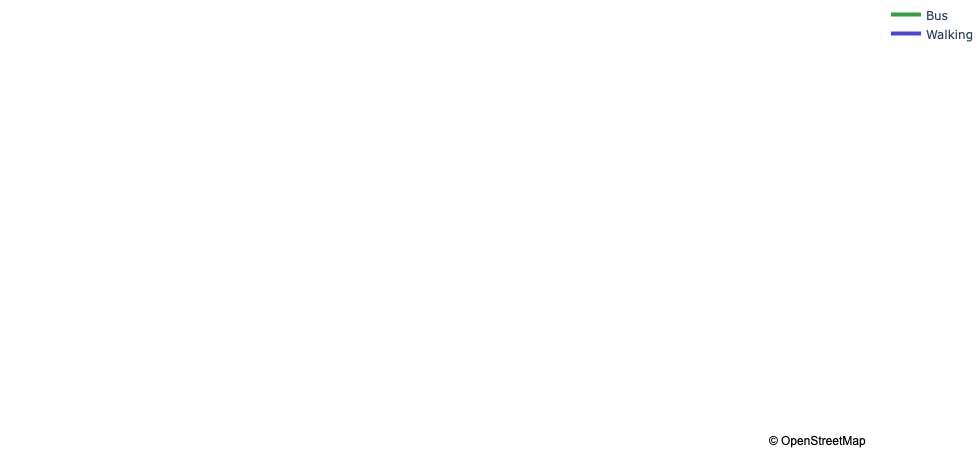



Alternative:  2
Confidence Level: 87.93%, Departure Time: 12:30:00

From "Zürich, ETH Hönggerberg" at 12:30:00 take Bus-"251.TA.26-69-j19-1.3.H" reaching "Zürich, Im Wingert" at 12:32:00
From "Zürich, Im Wingert" walk up to "Zürich, Schwert" (7 minutes needed)
From "Zürich, Schwert" at 12:42:00 take Bus-"220.TA.26-46-j19-1.8.H" reaching "Zürich, Central" at 12:54:00
From "Zürich, Central" walk up to "Zürich Polyterrasse" (4 minutes needed)




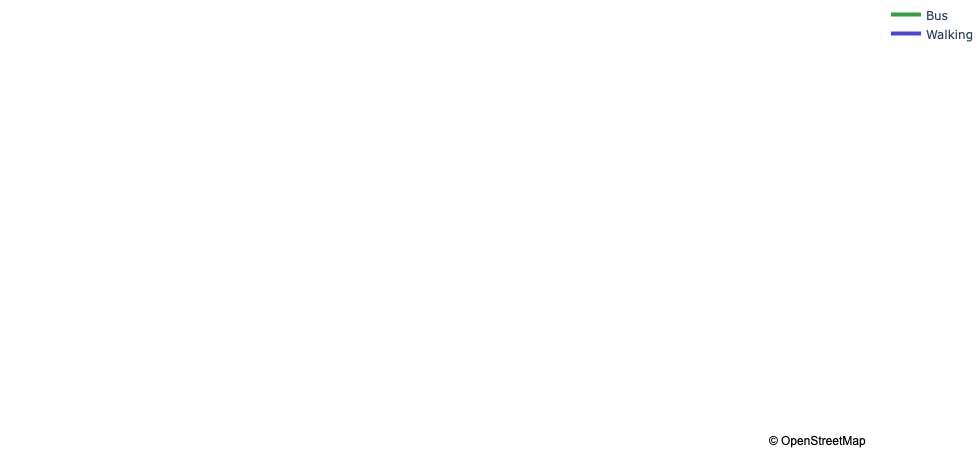



Alternative:  3
Confidence Level: 98.86%, Departure Time: 12:23:00

From "Zürich, ETH Hönggerberg" at 12:23:00 take Bus-"246.TA.26-69-j19-1.3.H" reaching "Zürich, Weihersteig" at 12:29:00
From "Zürich, Weihersteig" walk up to "Zürich, Bucheggplatz" (7 minutes needed)
From "Zürich, Bucheggplatz" at 12:39:00 take Tram-"1525.TA.26-17-j19-1.30.R" reaching "Zürich, Haldenegg" at 12:47:00
From "Zürich, Haldenegg" walk up to "Zürich Polyterrasse" (7 minutes needed)




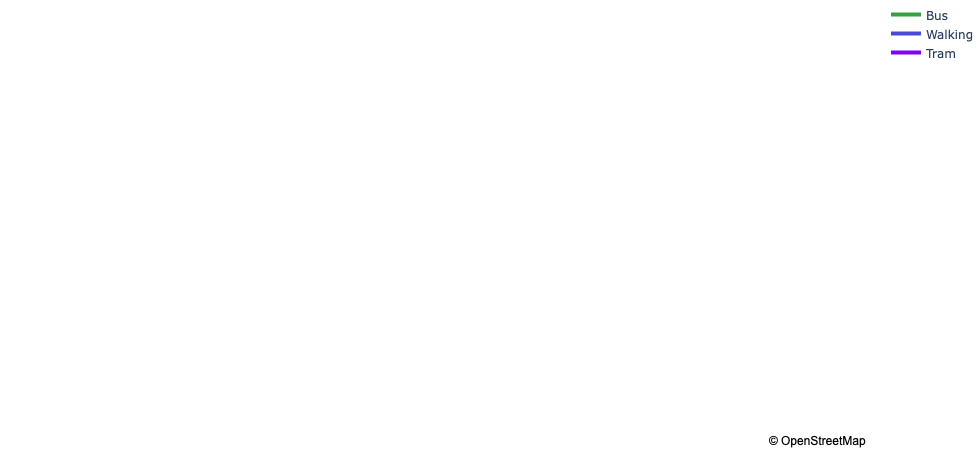



Alternative:  4
Confidence Level: 100.00%, Departure Time: 12:15:00

From "Zürich, ETH Hönggerberg" at 12:15:00 take Bus-"252.TA.26-69-j19-1.3.H" reaching "Zürich, Weihersteig" at 12:21:00
From "Zürich, Weihersteig" walk up to "Zürich, Bucheggplatz" (7 minutes needed)
From "Zürich, Bucheggplatz" at 12:38:00 take Tram-"2007.TA.26-7-B-j19-1.8.H" reaching "Zürich, Haldenegg" at 12:46:00
From "Zürich, Haldenegg" walk up to "Zürich Polyterrasse" (7 minutes needed)




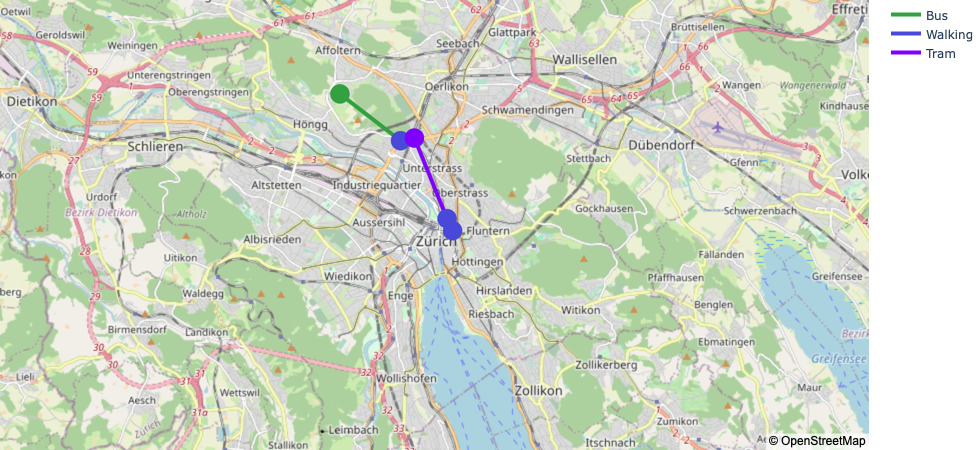

In [46]:
%%local

Q_0=0.5
starting_stop_0="8591122"
arrival_stop_0="8503500"
weekday_0=5
hour_0=13
minute_0=0

arrival_time_0=pd.to_datetime("%02d:%02d:00"%(hour_0,minute_0))


paths = query(starting_stop_0, arrival_stop_0, arrival_time_0, weekday_0, Q_0, [])
n_paths = len(paths)
if n_paths==1: print('An optimal paths is found!')
else: print('{} optimal paths are found!'.format(n_paths))

for i,path in enumerate(paths):
    print('\n\nAlternative: ', i+1)
    describe(path)
    visualize_path(path)

#### Here we can see that the probability as an influence on the trip, if we allow less probable trip we can take a connection which start even later.

An optimal paths is found!


Alternative:  1
Confidence Level: 100.00%, Departure Time: 12:34:00

From "Zürich, ETH Hönggerberg" at 12:34:00 take Bus-"153.TA.26-E-j19-1.5.H" reaching "Zürich, Haldenegg" at 12:47:00
From "Zürich, Haldenegg" walk up to "Zürich Polyterrasse" (7 minutes needed)




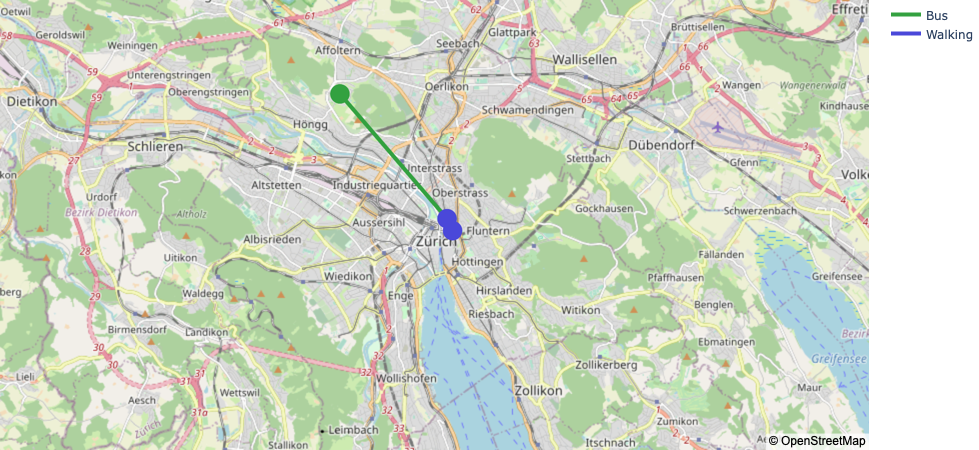

In [47]:
%%local
Q_0=0.75
starting_stop_0="8591122"
arrival_stop_0="8503500"
weekday_0=4#Friday
hour_0=13
minute_0=0

arrival_time_0=pd.to_datetime("%02d:%02d:00"%(hour_0,minute_0))

paths = query(starting_stop_0, arrival_stop_0, arrival_time_0, weekday_0, Q_0, [])
n_paths = len(paths)
if n_paths==1: print('An optimal paths is found!')
else: print('{} optimal paths are found!'.format(n_paths))

for i,path in enumerate(paths):
    print('\n\nAlternative: ', i+1)
    describe(path)
    visualize_path(path)

### Let's consider another longer path and compare it with GoogleMap

2 optimal paths are found!


Alternative:  1
Confidence Level: 98.08%, Departure Time: 12:19:00

From "Horgen, Dorfgasse" walk up to "Horgen" (5 minutes needed)
From "Horgen" at 12:24:00 take Train-"329.TA.26-2-j19-1.141.R" reaching "Zürich HB" at 12:42:00
From "Zürich HB" walk up to "Zürich HB" (0 minutes needed)
From "Zürich HB" at 12:49:00 take Train-"68.TA.26-19-j19-1.17.H" reaching "Zürich Oerlikon" at 12:54:00
From "Zürich Oerlikon" walk up to "Zürich Oerlikon" (1 minutes needed)




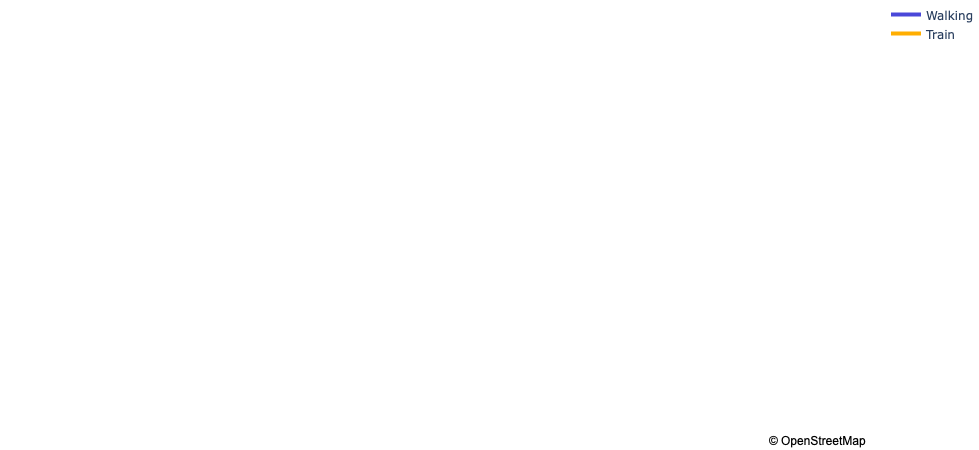



Alternative:  2
Confidence Level: 100.00%, Departure Time: 12:19:00

From "Horgen, Dorfgasse" walk up to "Horgen" (5 minutes needed)
From "Horgen" at 12:24:00 take Train-"329.TA.26-2-j19-1.141.R" reaching "Zürich Oerlikon" at 12:48:00
From "Zürich Oerlikon" walk up to "Zürich Oerlikon" (1 minutes needed)




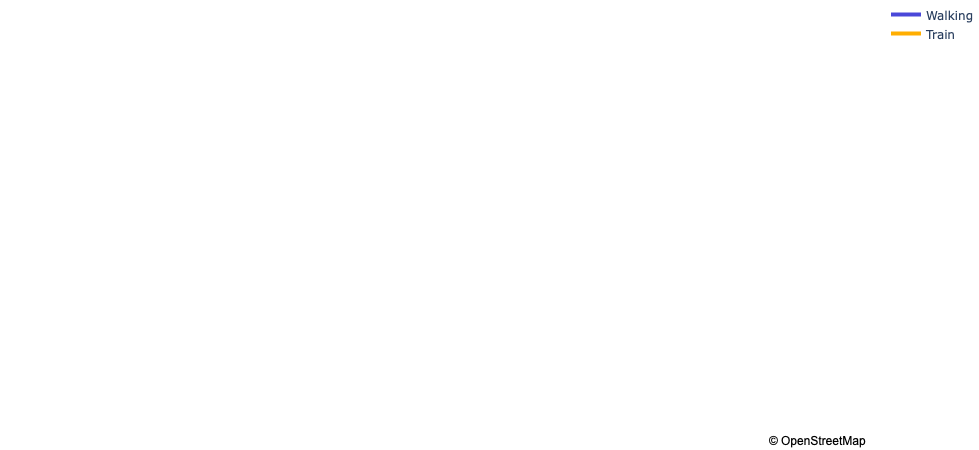

In [48]:
%%local

Q_0=0.95
starting_stop_0="8590651"
arrival_stop_0="8503006:0:4"
weekday_0=4#Friday
hour_0=13
minute_0=0

arrival_time_0=pd.to_datetime("%02d:%02d:00"%(hour_0,minute_0))

paths = query(starting_stop_0, arrival_stop_0, arrival_time_0, weekday_0, Q_0, [])

n_paths = len(paths)
if n_paths==1: print('An optimal paths is found!')
else: print('{} optimal paths are found!'.format(n_paths))

for i,path in enumerate(paths):
    print('\n\nAlternative: ', i+1)
    describe(path)
    visualize_path(path)


(This cell usually don't display automatically, just make any modification, like adding a space, and rerun the cell)

![trip_image](../figs/trip_image.PNG)

![trip_textual](../figs/trip_textual.PNG)

### Our second trip is equivalent to the trip suggested by GoogleMap because GoogleMap try to minimize the number of changes